In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import *
from sklearn.model_selection import train_test_split


In [2]:
data = pd.read_csv("./data/AIDS_Classification.csv")
data.head(1)

,time,trt,age,wtkg,hemo,homo,drugs,karnof,oprior,z30,...,str2,strat,symptom,treat,offtrt,cd40,cd420,cd80,cd820,infected
0,948,2,48,89.8128,0,0,0,100,0,0,...,0,1,0,1,0,422,477,566,324,0


### 006 EDA - Dataset Structure

In [3]:
## number of rows and columns of the tabular data 
data.shape

(2139, 23)

In [4]:
## all data is integer except `wtkg`
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2139 entries, 0 to 2138
Data columns (total 23 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   time      2139 non-null   int64  
 1   trt       2139 non-null   int64  
 2   age       2139 non-null   int64  
 3   wtkg      2139 non-null   float64
 4   hemo      2139 non-null   int64  
 5   homo      2139 non-null   int64  
 6   drugs     2139 non-null   int64  
 7   karnof    2139 non-null   int64  
 8   oprior    2139 non-null   int64  
 9   z30       2139 non-null   int64  
 10  preanti   2139 non-null   int64  
 11  race      2139 non-null   int64  
 12  gender    2139 non-null   int64  
 13  str2      2139 non-null   int64  
 14  strat     2139 non-null   int64  
 15  symptom   2139 non-null   int64  
 16  treat     2139 non-null   int64  
 17  offtrt    2139 non-null   int64  
 18  cd40      2139 non-null   int64  
 19  cd420     2139 non-null   int64  
 20  cd80      2139 non-null   int6

### 007 Missing values


In [5]:
#there is no missing value
data.isnull().sum()

time        0
trt         0
age         0
wtkg        0
hemo        0
homo        0
drugs       0
karnof      0
oprior      0
z30         0
preanti     0
race        0
gender      0
str2        0
strat       0
symptom     0
treat       0
offtrt      0
cd40        0
cd420       0
cd80        0
cd820       0
infected    0
dtype: int64

### 008 Target is binary 

In [6]:
# The target variable 'infected' is binary
data['infected'].nunique()

2

### 009 Class imbalance 

infected
0    1618
1     521
Name: count, dtype: int64
Proportion of infected: 24.36%


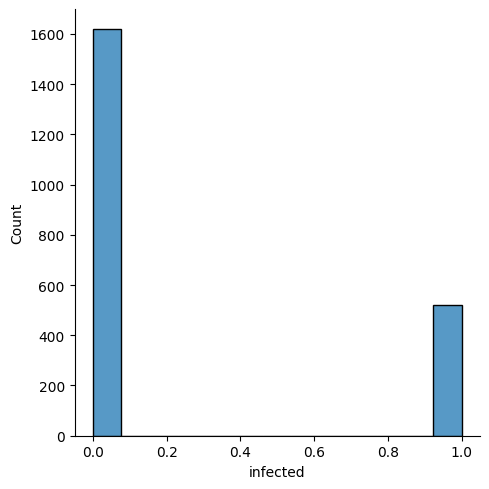

In [7]:
# The target class is moderately imbalanced : the positive class "infected" has the least numerosity 
count_infected_df = data['infected'].value_counts()
proportion_infected = count_infected_df[1]/(count_infected_df.sum())
print(count_infected_df)
print(f"Proportion of infected: {round(proportion_infected*100,2)}%")

sns.displot(data = data, x = 'infected')
plt.show()

### 010 Missing values strategy


There are no missing values in the dataset

#### 010 - the case of zero cd40 

We saw that there are no Null values in the data. However, for numerical features, missing values may have been recordeds as "zeros". There are 9 numerical features, two multiclass categorical features and 12 binary features (including the target). 

In [34]:
continuous_variables = "time age wtkg karnof preanti cd40 cd420 cd80 cd820".split()
data[continuous_variables].describe()

,time,age,wtkg,karnof,preanti,cd40,cd420,cd80,cd820
count,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000
mean,879.098177,35.248247,75.125311,95.446470,379.175783,350.501169,371.307153,986.627396,935.369799
std,292.274324,8.709026,13.263164,5.900985,468.657526,118.573863,144.634909,480.197750,444.976051
min,14.000000,12.000000,31.000000,70.000000,0.000000,0.000000,49.000000,40.000000,124.000000
25%,727.000000,29.000000,66.679200,90.000000,0.000000,263.500000,269.000000,654.000000,631.500000
50%,997.000000,34.000000,74.390400,100.000000,142.000000,340.000000,353.000000,893.000000,865.000000
75%,1091.000000,40.000000,82.555200,100.000000,739.500000,423.000000,460.000000,1207.000000,1146.500000
max,1231.000000,70.000000,159.939360,100.000000,2851.000000,1199.000000,1119.000000,5011.000000,6035.000000


The  minimum value for 'preanti' is 0, but this is normal, since it corresponds to the patients that started antiretroviral treatment contextually with this study. The minimum value for `cd40' may actually be 0, although this is unlikely since it is the number of cd4 cells per mm3 blood, and the average in the dataset is 350. Some inspection is required. 

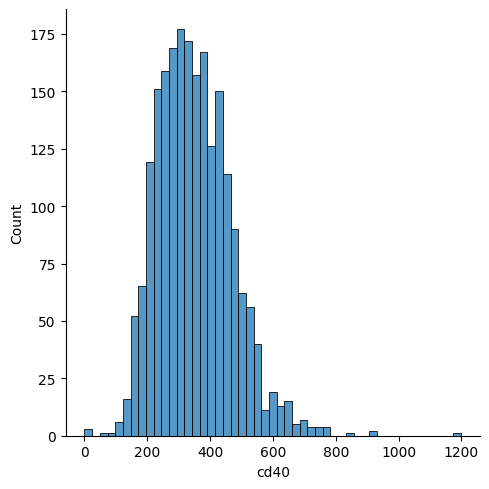

In [37]:
sns.displot(data= data, x= 'cd40')

In [48]:
data_zero_cd40 = data[data['cd40']==0]
data_zero_cd40

,time,trt,age,wtkg,hemo,homo,drugs,karnof,oprior,z30,...,str2,strat,symptom,treat,offtrt,cd40,cd420,cd80,cd820,infected
216,1027,1,45,67.1000,0,1,0,100,0,1,...,1,3,0,1,0,0,359,468,659,0
217,985,1,60,51.6000,0,0,0,100,0,1,...,1,3,0,1,1,0,523,1087,1727,0
723,1124,1,30,81.1944,0,1,1,100,0,0,...,0,1,0,1,1,0,566,998,1078,0


There are three patients with zero cd4 count. 

In [49]:
data[data['cd40']<120]

,time,trt,age,wtkg,hemo,homo,drugs,karnof,oprior,z30,...,str2,strat,symptom,treat,offtrt,cd40,cd420,cd80,cd820,infected
216,1027,1,45,67.1000,0,1,0,100,0,1,...,1,3,0,1,0,0,359,468,659,0
217,985,1,60,51.6000,0,0,0,100,0,1,...,1,3,0,1,1,0,523,1087,1727,0
285,1089,1,48,91.1736,0,1,0,100,0,1,...,1,3,0,1,0,84,541,706,1516,0
358,1022,0,34,79.6000,0,1,0,100,0,0,...,0,1,1,0,1,103,237,1084,1313,0
723,1124,1,30,81.1944,0,1,1,100,0,0,...,0,1,0,1,1,0,566,998,1078,0
1455,1029,1,43,101.0000,0,1,0,100,0,0,...,1,2,0,1,1,70,197,314,893,0
1667,1001,2,41,65.0916,1,0,0,100,1,0,...,1,3,0,1,1,99,80,105,173,0
1920,904,3,33,75.5000,0,1,0,90,0,0,...,0,1,0,1,1,112,348,291,541,1
1993,885,3,47,62.5968,0,0,0,90,0,1,...,1,3,0,1,1,110,80,230,140,1


Comparing with "low cd40" patients, we do not find enough evidence to infer that the null cd40 is to be treated as a "missing" value. We will consider this in the "outlier" analysis though.  

## 011 numerical distributions

In [ ]:
for col in 

<Axes: xlabel='time', ylabel='Count'>

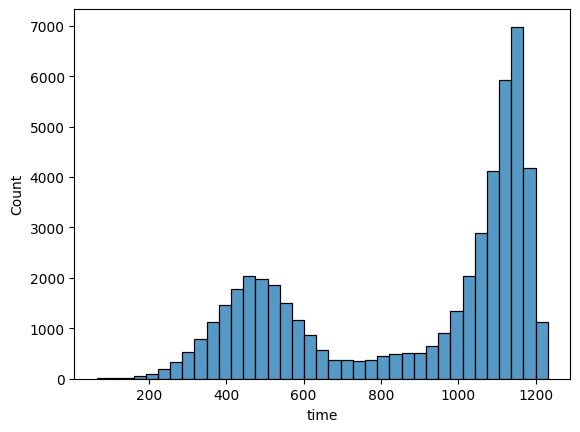

In [44]:
sns.histplot(data,x="time")

<Axes: xlabel='time'>

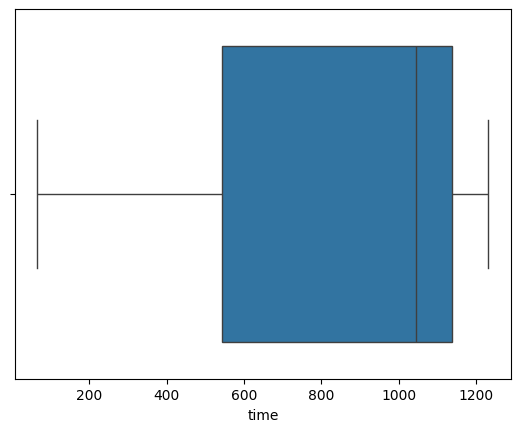

In [45]:
sns.boxplot(data,x="time")

<Axes: xlabel='age', ylabel='Count'>

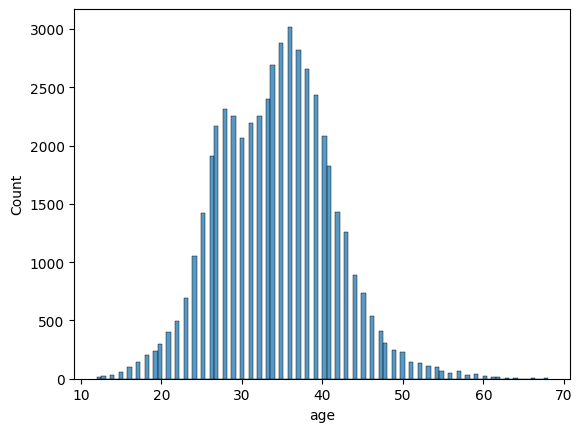

In [33]:
sns.histplot(data,x="age")

<Axes: xlabel='age'>

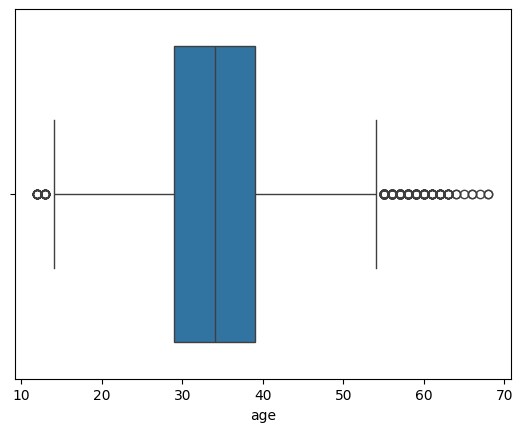

In [46]:
sns.boxplot(data,x="age")

<Axes: xlabel='wtkg', ylabel='Count'>

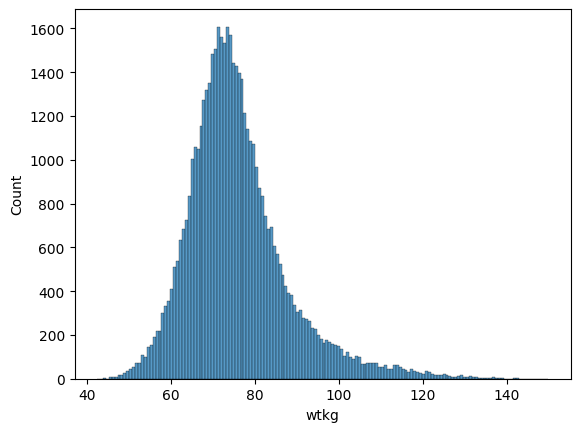

In [34]:
sns.histplot(data,x="wtkg")

<Axes: xlabel='wtkg'>

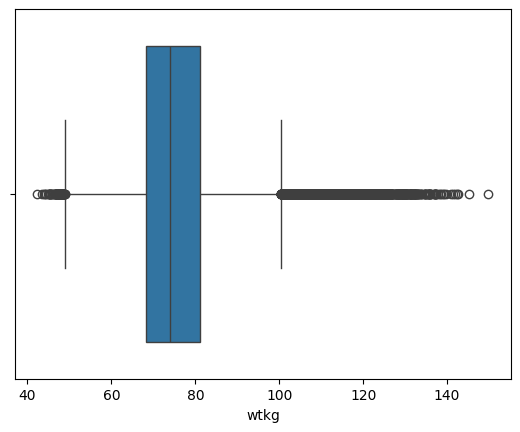

In [47]:
sns.boxplot(data,x="wtkg")

<Axes: xlabel='karnof', ylabel='Count'>

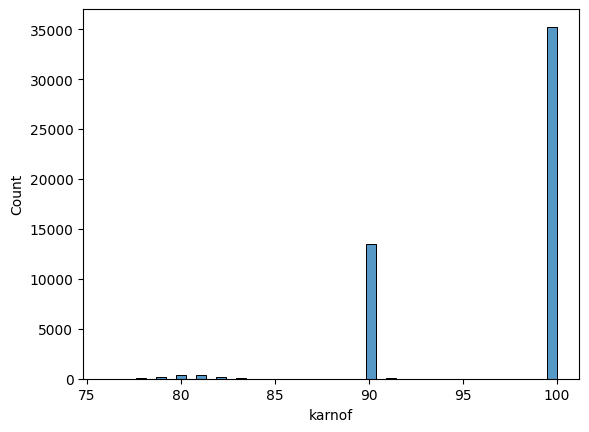

In [35]:
sns.histplot(data,x="karnof")

<Axes: xlabel='karnof'>

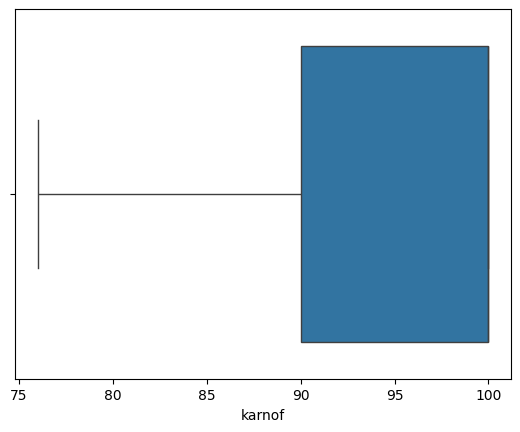

In [48]:
sns.boxplot(data,x="karnof")

<Axes: xlabel='cd40', ylabel='Count'>

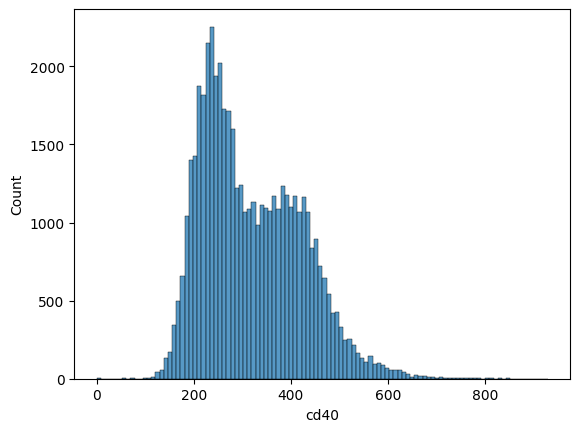

In [37]:
sns.histplot(data,x="cd40")

<Axes: xlabel='cd40'>

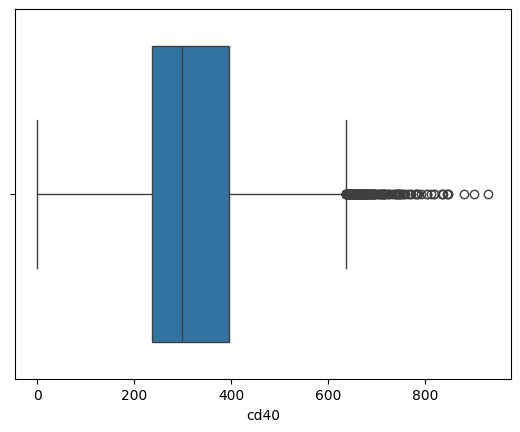

In [49]:
sns.boxplot(data,x="cd40")

<Axes: xlabel='cd420', ylabel='Count'>

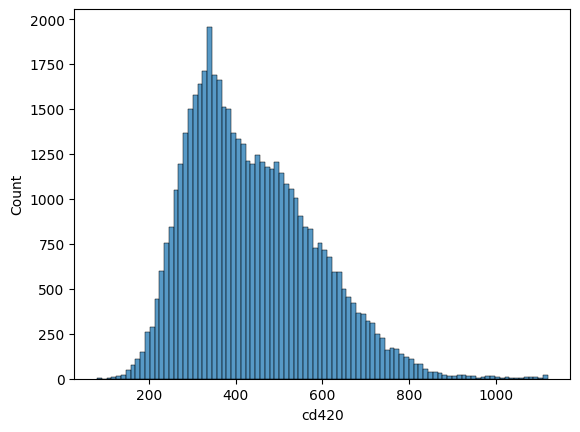

In [38]:
sns.histplot(data,x="cd420")

<Axes: xlabel='cd420'>

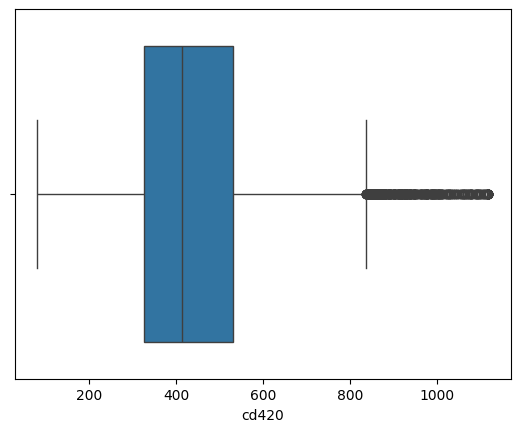

In [50]:
sns.boxplot(data,x="cd420")

<Axes: xlabel='cd80', ylabel='Count'>

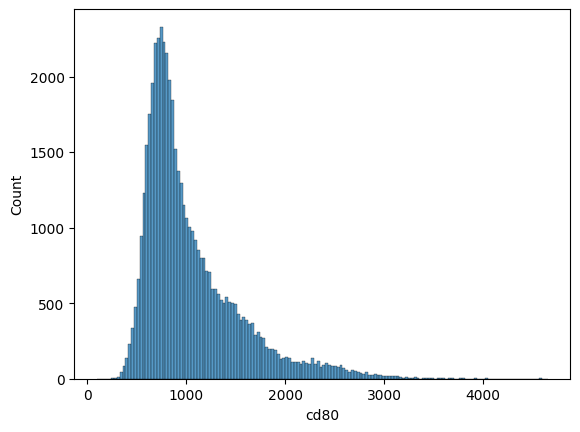

In [39]:
sns.histplot(data,x="cd80")

<Axes: xlabel='cd80'>

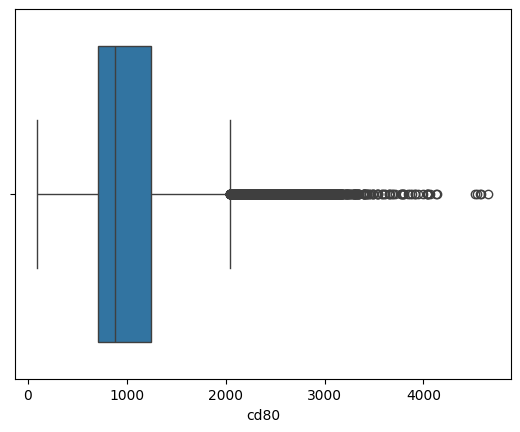

In [51]:
sns.boxplot(data,x="cd80")

<Axes: xlabel='cd820', ylabel='Count'>

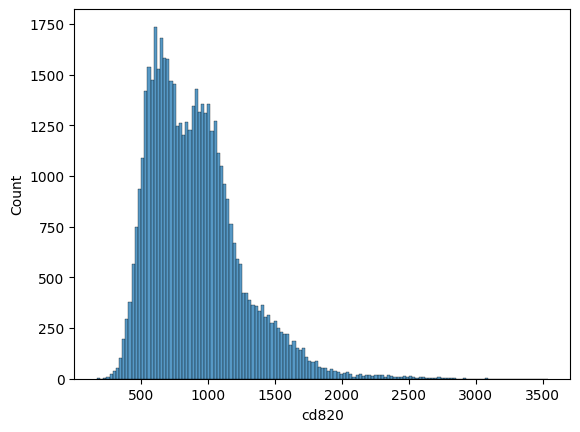

In [40]:
sns.histplot(data,x="cd820")

<Axes: xlabel='cd820'>

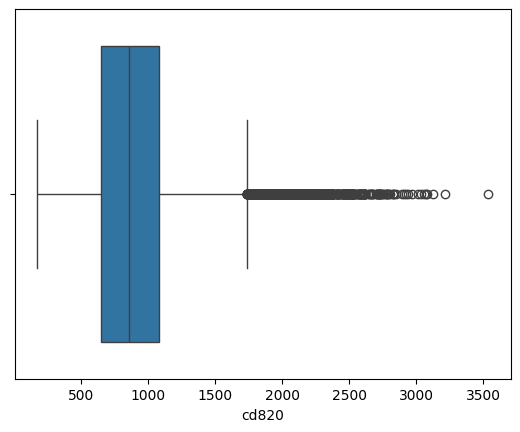

In [52]:
sns.boxplot(data,x="cd820")

## 012

### 013 Temporal analysis



There is no truly timestamped data so we cannot analyze time series for temporal patterns. We do have a "time" variable though, that measures the total time a patient followed the treatment, from start to failure or censoring. We also have the "preanti" variable that measures the time spent in antiretroviral therapy before the beginning of this study. In some sense, we can see "preanti" as a time variable that looks into the past, while "time" looks into the future.

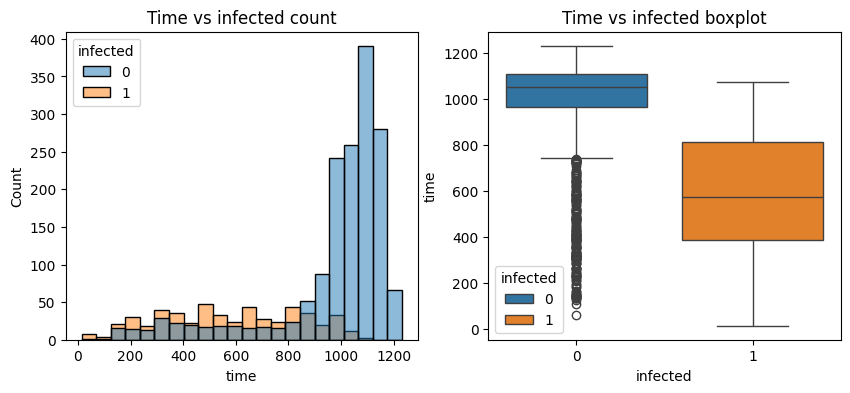

In [42]:
# Plot time vs infected

fig,axes = plt.subplots(1,2,figsize = (10,4), sharey = False)

sns.histplot(data = data, x= "time", hue = "infected", ax = axes[0])
sns.boxplot(data = data, x="infected", y = "time", hue = "infected", orient = "v", ax = axes[1])

axes[0].set_title('Time vs infected count')
axes[1].set_title('Time vs infected boxplot')
plt.show()

Conclusion: patients with time > 3 years thend not to be infected.

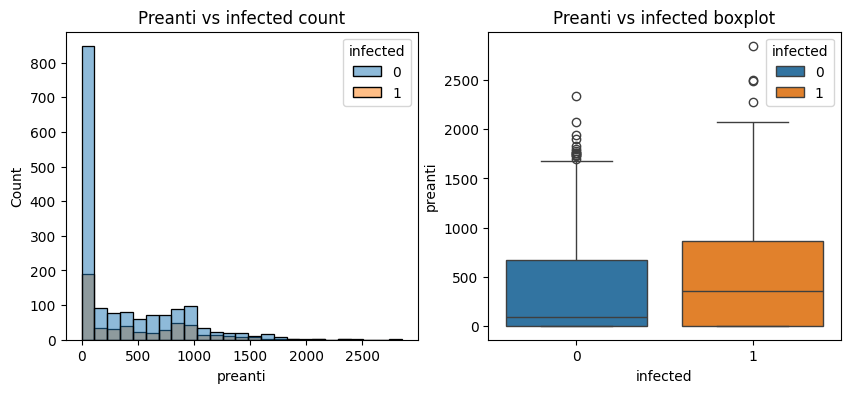

In [43]:
# Plot preanti vs infected

fig,axes = plt.subplots(1,2,figsize = (10,4), sharey = False)

sns.histplot(data = data, x= "preanti", hue = "infected", ax = axes[0])
sns.boxplot(data = data, x="infected", y = "preanti", hue = "infected", orient = "v", ax = axes[1])

axes[0].set_title('Preanti vs infected count')
axes[1].set_title('Preanti vs infected boxplot')
plt.show()

Conclusion: when preanti > 0, the distribution of "preanti" is similar for infected and non-infected patients. When preanti = 0 the proportion of "not-infected" is higher